In [ ]:
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn, optim
import torch.nn.functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
import os
import copy

from torchview import draw_graph
from torchsummary import summary
from sklearn import preprocessing

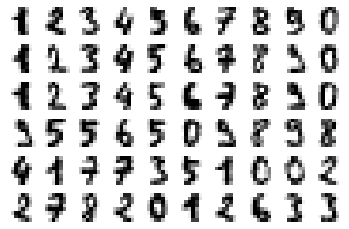

In [ ]:
NUM_CHANNEL = 1
NUM_CLASS = 10 #0-9 class

lb = preprocessing.LabelBinarizer()

digits = datasets.load_digits()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(digits.images[index], cmap='gray_r')

_, width, height = digits.images.shape
lb.fit(digits.target)
X_train, X_test, y_train, y_test = train_test_split(digits.images.reshape(-1,1,width,height)/255, lb.transform(digits.target), train_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

X_train = torch.Tensor(X_train) # transform to torch tensor
y_train = torch.Tensor(y_train)
X_valid = torch.Tensor(X_valid)
y_valid = torch.Tensor(y_valid)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

Tr_set = TensorDataset(X_train,y_train) # create your datset
Tr_dataloader = DataLoader(Tr_set,batch_size=128, shuffle=True) # create your dataloader
Va_set = TensorDataset(X_valid,y_valid)
Va_dataloader = DataLoader(Va_set,batch_size=128, shuffle=True)
Ts_set = TensorDataset(X_test,y_test)
Ts_dataloader = DataLoader(Ts_set,batch_size=128, shuffle=True)

In [ ]:
# Device 'cuda' or 'cuda:0' means GPU slot 0.
# If you have more than one GPU, you can select other GPUs using 'cuda:1', 'cuda:2', etc.
# In terminal (Linux), you can check memory using in each GPU by using command
# $ nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.

            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in

            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.

                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, dim=1)

                    # Backpropagate only if in training phase

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(labels.data, dim=1))

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()

            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

Using device cpu


AlexNet model

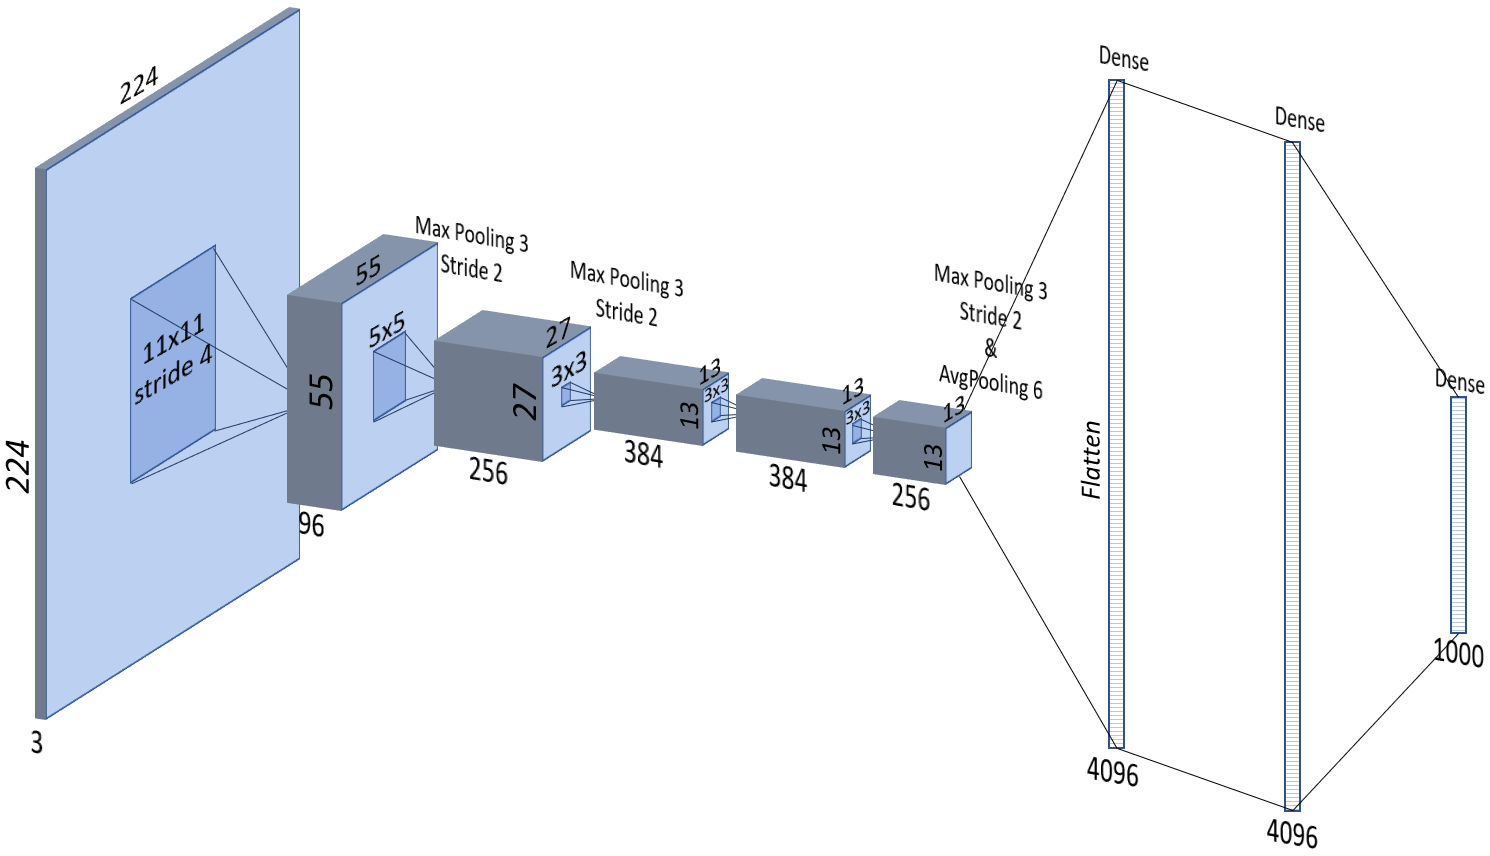

# AlexNet Coding in PyTorch



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Resize-1          [-1, 1, 224, 224]               0
            Conv2d-2           [-1, 96, 55, 55]          11,712
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
         MaxPool2d-7          [-1, 256, 13, 13]               0
            Conv2d-8          [-1, 384, 13, 13]         885,120
              ReLU-9          [-1, 384, 13, 13]               0
           Conv2d-10          [-1, 384, 13, 13]       1,327,488
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 256, 13, 13]         884,992
             ReLU-13          [-1, 256, 13, 13]               0
        MaxPool2d-14            [-1, 25

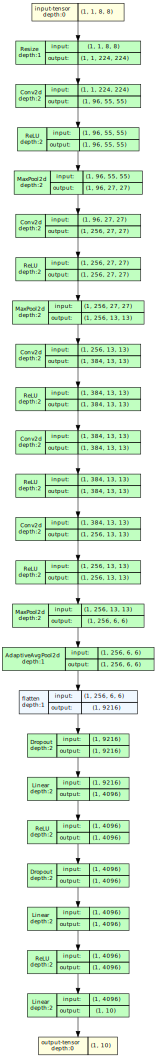

In [ ]:
class AlexNet(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(NUM_CHANNEL, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, NUM_CLASS),
            # nn.Softmax(),
        )
        self.resize = transforms.Resize(224)

    def forward(self, x):
        x = self.resize(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to target device
alexnet = AlexNet().to(device)
3
# Show the details of the network
summary(alexnet, input_size=(NUM_CHANNEL,width,height))
draw_graph(alexnet, input_size=(1,NUM_CHANNEL,width,height)).visual_graph

In [ ]:
# CrossEntropyLoss for multinomial classification (because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet.parameters()
# Use Adam algorithm for update weights in model
optimizer = optim.Adam(params_to_update, lr=0.001)

dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}

best_model, val_acc_history, loss_acc_history = train_model(alexnet, dataloaders, criterion, optimizer, 10, 'alexnet')

Epoch 0/9
----------
train Loss: 2.3036 Acc: 0.0940
Epoch time taken:  136.22941875457764
val Loss: 2.3039 Acc: 0.0868
Epoch time taken:  148.13168692588806

Epoch 1/9
----------
train Loss: 4.8455 Acc: 0.0766
Epoch time taken:  141.5495355129242
val Loss: 2.2971 Acc: 0.0764
Epoch time taken:  152.4664409160614

Epoch 2/9
----------
train Loss: 2.3001 Acc: 0.1070
Epoch time taken:  136.07535791397095
val Loss: 2.3059 Acc: 0.1042
Epoch time taken:  146.7839436531067

Epoch 3/9
----------
train Loss: 2.3013 Acc: 0.1097
Epoch time taken:  135.93927311897278
val Loss: 2.3068 Acc: 0.1042
Epoch time taken:  146.70032906532288

Epoch 4/9
----------
train Loss: 2.3009 Acc: 0.1097
Epoch time taken:  147.534565448761
val Loss: 2.3066 Acc: 0.1042
Epoch time taken:  158.29386067390442

Epoch 5/9
----------
train Loss: 2.3006 Acc: 0.1097
Epoch time taken:  144.24294662475586
val Loss: 2.3066 Acc: 0.1042
Epoch time taken:  155.19785952568054

Epoch 6/9
----------
train Loss: 2.3018 Acc: 0.1097
Epoch

In [ ]:
correct_count = 0
count = 0
for images, labels in Ts_dataloader:
    for i in range(len(labels)):
        image = images[i].view(1,1,width,height)
        with torch.no_grad():
            y_output = alexnet(image)

        prob = list(y_output.numpy()[0])
        pred_label = prob.index(max(prob))
        true_label = np.argmax(labels.numpy()[i])
        if true_label==pred_label:
            correct_count += 1
        count += 1

print("Accuracy = ", (correct_count/count))


Accuracy =  0.075


# GoogLeNet Coding in PyTorch


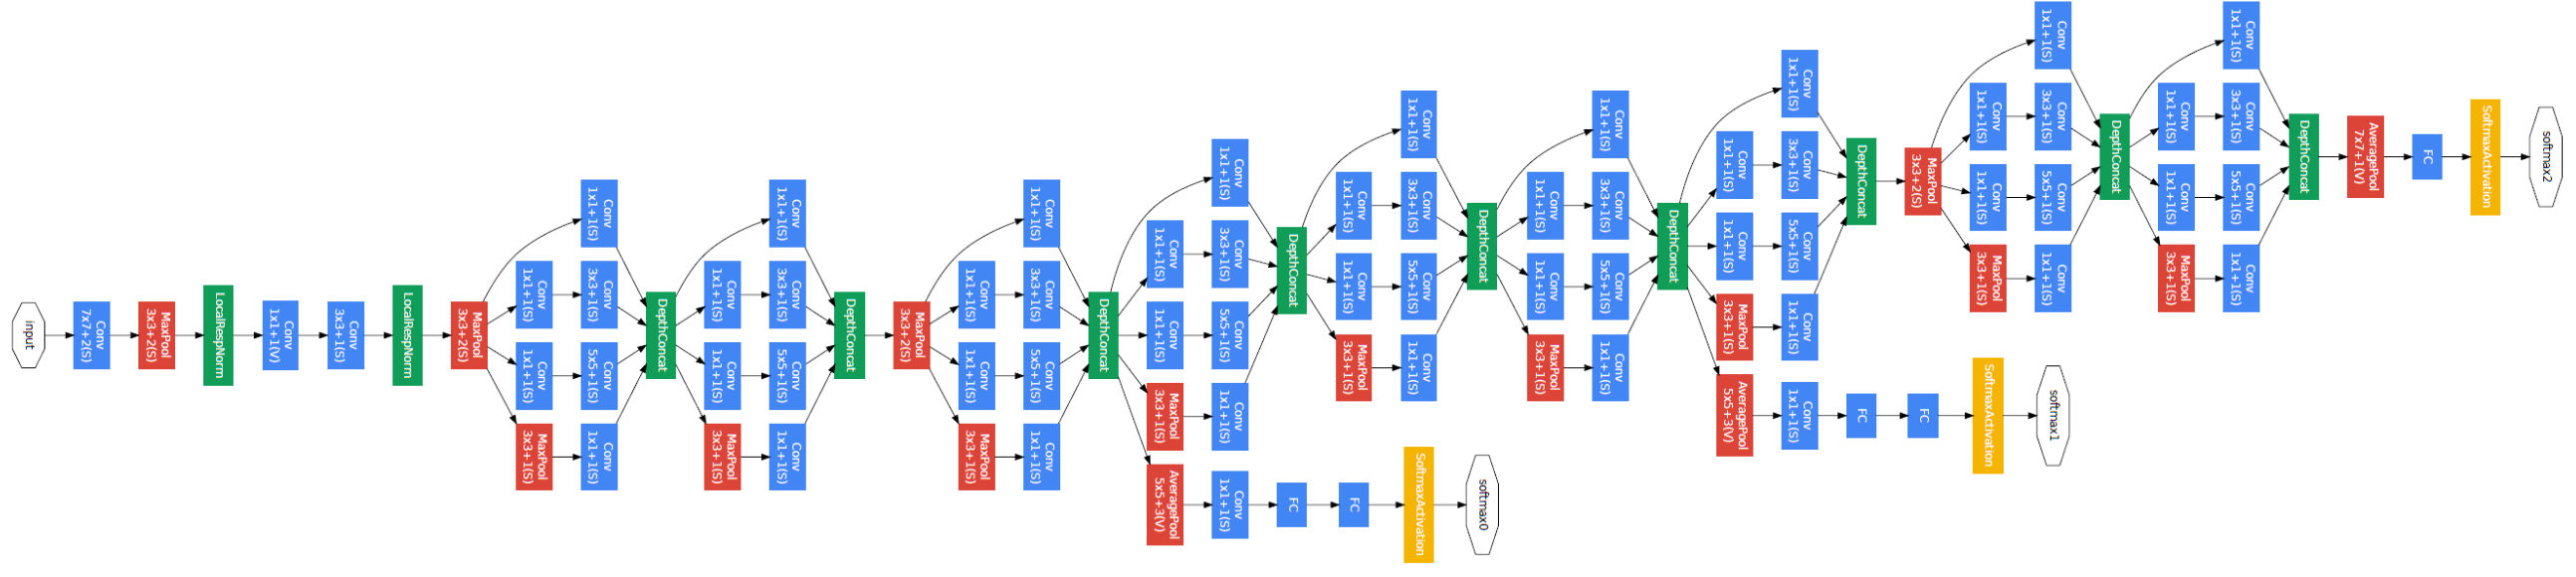


# Inception block


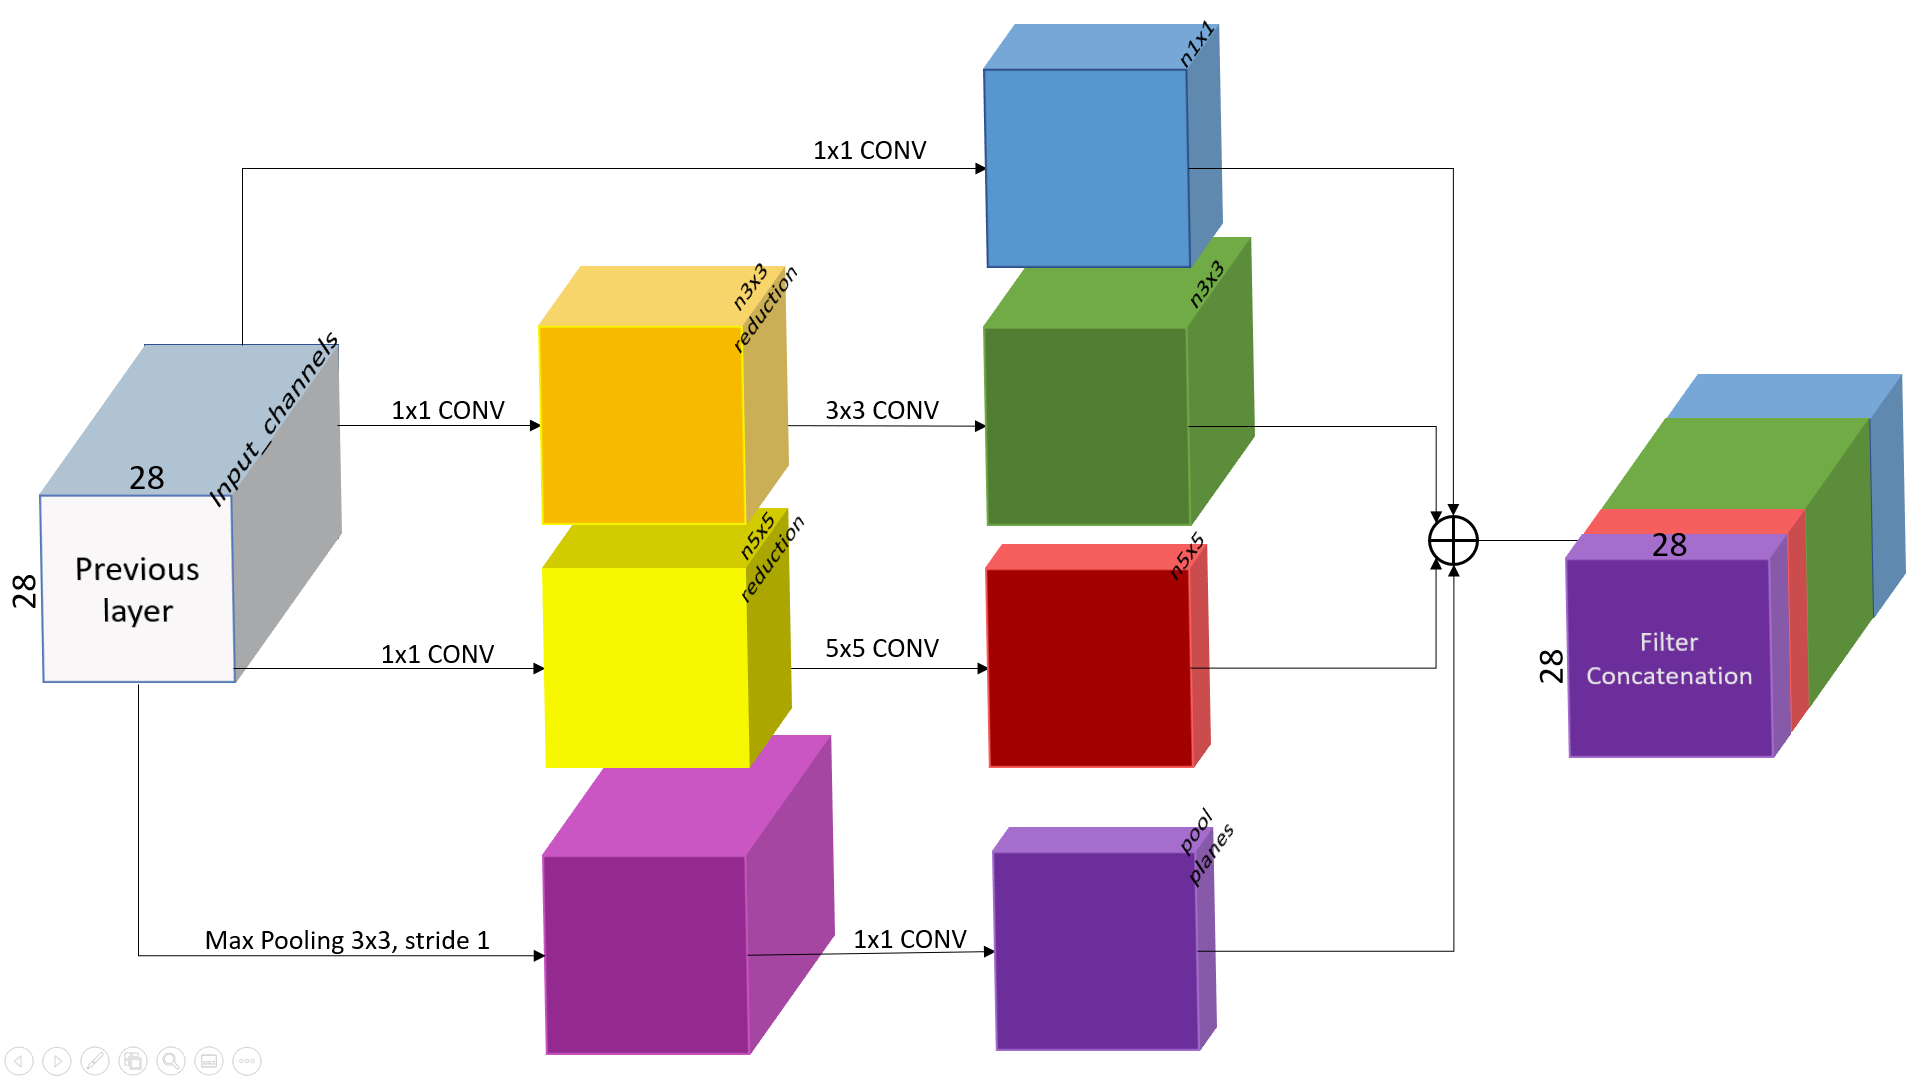

In [ ]:
class Inception(nn.Module):
    '''
    Inception block for a GoogLeNet-like CNN

    Attributes
    ----------
    in_planes : int
        Number of input feature maps
    n1x1 : int
        Number of direct 1x1 convolutions
    n3x3red : int
        Number of 1x1 reductions before the 3x3 convolutions
    n3x3 : int
        Number of 3x3 convolutions
    n5x5red : int
        Number of 1x1 reductions before the 5x5 convolutions
    n5x5 : int
        Number of 5x5 convolutions
    pool_planes : int
        Number of 1x1 convolutions after 3x3 max pooling
    b1 : Sequential
        First branch (direct 1x1 convolutions)
    b2 : Sequential
        Second branch (reduction then 3x3 convolutions)
    b3 : Sequential
        Third branch (reduction then 5x5 convolutions)
    b4 : Sequential
        Fourth branch (max pooling then reduction)
    '''

    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes

        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Resize-1            [-1, 1, 32, 32]               0
            Conv2d-2          [-1, 192, 32, 32]           1,920
       BatchNorm2d-3          [-1, 192, 32, 32]             384
              ReLU-4          [-1, 192, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          12,352
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 96, 32, 32]          18,528
       BatchNorm2d-9           [-1, 96, 32, 32]             192
             ReLU-10           [-1, 96, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         110,720
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 16,

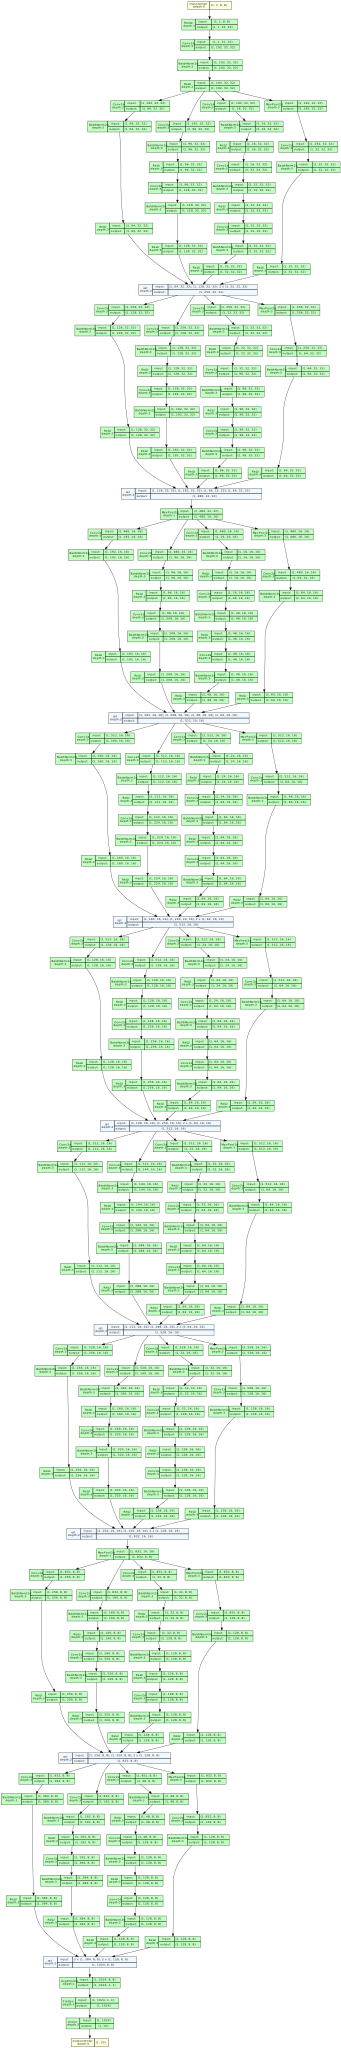

In [ ]:
class GoogLeNet(nn.Module):
    '''
    GoogLeNet-like CNN

    Attributes
    ----------
    pre_layers : Sequential
        Initial convolutional layer
    a3 : Inception
        First inception block
    b3 : Inception
        Second inception block
    maxpool : MaxPool2d
        Pooling layer after second inception block
    a4 : Inception
        Third inception block
    b4 : Inception
        Fourth inception block
    c4 : Inception
        Fifth inception block
    d4 : Inception
        Sixth inception block
    e4 : Inception
        Seventh inception block
    a5 : Inception
        Eighth inception block
    b5 : Inception
        Ninth inception block
    avgpool : AvgPool2d
        Average pool layer after final inception block
    linear : Linear
        Fully connected layer
    '''

    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(NUM_CHANNEL, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(1024, NUM_CLASS),
            nn.LazyLinear(NUM_CLASS),
            )
        self.resize = transforms.Resize(32)

    def forward(self, x):
        out = self.resize(x)
        out = self.pre_layers(out)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = self.linear(out)
        return out

# Move model to target device
googlenet = GoogLeNet().to(device)

# Show the details of the network
summary(googlenet, input_size=(NUM_CHANNEL,width,height))
draw_graph(googlenet, input_size=(1,NUM_CHANNEL,width,height)).visual_graph

In [ ]:
# CrossEntropyLoss for multinomial classification (because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = googlenet.parameters()
# Use Adam algorithm for update weights in model
optimizer = optim.Adam(params_to_update, lr=0.001)

dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}

best_model, val_acc_history, loss_acc_history = train_model(googlenet, dataloaders, criterion, optimizer, 10, 'googlenet')

Epoch 0/9
----------
train Loss: 1.1668 Acc: 0.6510
Epoch time taken:  266.6908218860626
val Loss: 3.3258 Acc: 0.1042
Epoch time taken:  292.04176688194275

Epoch 1/9
----------
train Loss: 0.1374 Acc: 0.9782
Epoch time taken:  257.4774875640869
val Loss: 5.4478 Acc: 0.1042
Epoch time taken:  283.8880717754364

Epoch 2/9
----------
train Loss: 0.0519 Acc: 0.9913
Epoch time taken:  263.58913564682007
val Loss: 5.9656 Acc: 0.1042
Epoch time taken:  290.30425906181335

Epoch 3/9
----------
train Loss: 0.0370 Acc: 0.9913
Epoch time taken:  261.20309567451477
val Loss: 7.1708 Acc: 0.1181
Epoch time taken:  287.80014419555664

Epoch 4/9
----------
train Loss: 0.0278 Acc: 0.9939
Epoch time taken:  271.0426459312439
val Loss: 7.4794 Acc: 0.1042
Epoch time taken:  297.3408932685852

Epoch 5/9
----------
train Loss: 0.0214 Acc: 0.9939
Epoch time taken:  258.1477692127228
val Loss: 5.0132 Acc: 0.2222
Epoch time taken:  284.3775556087494

Epoch 6/9
----------
train Loss: 0.0185 Acc: 0.9983
Epoch t

In [ ]:
correct_count = 0
count = 0
for images, labels in Ts_dataloader:
    for i in range(len(labels)):
        image = images[i].view(1,1,width,height)
        with torch.no_grad():
            y_output = googlenet(image)

        prob = list(y_output.numpy()[0])
        pred_label = prob.index(max(prob))
        true_label = np.argmax(labels.numpy()[i])
        if true_label==pred_label:
            correct_count += 1
        count += 1

print("Accuracy = ", (correct_count/count))

Accuracy =  0.8444444444444444


# Residual Network (ResNet) Coding in PyTorch

In [ ]:
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             576
       BatchNorm2d-2             [-1, 64, 8, 8]             128
            Conv2d-3             [-1, 64, 8, 8]          36,864
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
        BasicBlock-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
           Conv2d-10             [-1, 64, 8, 8]          36,864
      BatchNorm2d-11             [-1, 64, 8, 8]             128
       BasicBlock-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]          73,728
      BatchNorm2d-14            [-1, 12

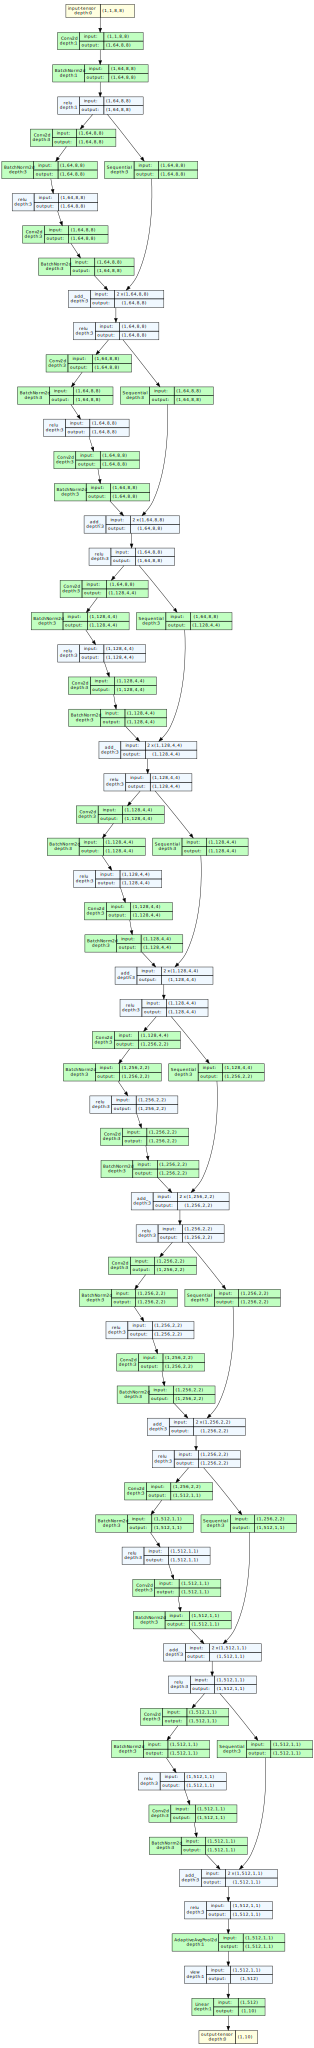

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(NUM_CHANNEL, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

resnet = ResNet(BasicBlock, [2, 2, 2, 2], NUM_CLASS).to(device)

# Show the details of the network
summary(resnet, input_size=(NUM_CHANNEL,width,height))
draw_graph(resnet, input_size=(1,NUM_CHANNEL,width,height)).visual_graph

In [ ]:
# CrossEntropyLoss for multinomial classification (because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = resnet.parameters()
# Use Adam algorithm for update weights in model
optimizer = optim.Adam(params_to_update, lr=0.01)

dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}

best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 10, 'resnet')

Epoch 0/9
----------
train Loss: 2.6051 Acc: 0.3499
Epoch time taken:  10.79538893699646
val Loss: 849.8310 Acc: 0.1042
Epoch time taken:  11.370558261871338

Epoch 1/9
----------
train Loss: 0.5766 Acc: 0.8146
Epoch time taken:  12.286597967147827
val Loss: 230.5214 Acc: 0.1042
Epoch time taken:  12.860737562179565

Epoch 2/9
----------
train Loss: 0.2279 Acc: 0.9234
Epoch time taken:  10.729071855545044
val Loss: 37.4891 Acc: 0.1042
Epoch time taken:  11.300343751907349

Epoch 3/9
----------
train Loss: 0.1036 Acc: 0.9669
Epoch time taken:  10.7865149974823
val Loss: 7.8181 Acc: 0.1042
Epoch time taken:  11.358899593353271

Epoch 4/9
----------
train Loss: 0.0556 Acc: 0.9800
Epoch time taken:  11.565269947052002
val Loss: 4.8480 Acc: 0.1875
Epoch time taken:  12.2230544090271

Epoch 5/9
----------
train Loss: 0.0517 Acc: 0.9835
Epoch time taken:  10.550663948059082
val Loss: 3.5275 Acc: 0.2535
Epoch time taken:  11.091195583343506

Epoch 6/9
----------
train Loss: 0.0465 Acc: 0.9826


In [ ]:
correct_count = 0
count = 0
for images, labels in Ts_dataloader:
    for i in range(len(labels)):
        image = images[i].view(1,1,width,height)
        with torch.no_grad():
            y_output = googlenet(image)

        prob = list(y_output.numpy()[0])
        pred_label = prob.index(max(prob))
        true_label = np.argmax(labels.numpy()[i])
        if true_label==pred_label:
            correct_count += 1
        count += 1

print("Accuracy = ", (correct_count/count))

Accuracy =  0.6055555555555555


# Squeeze-and-Excitation Networks (SENet) Coding in PyTorch

In [ ]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
class ResidualSEBasicBlock(nn.Module):
    '''
    ResidualSEBasicBlock: Standard two-convolution residual block with an SE Module between the
                          second convolution and the identity addition
    '''
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with a 1x1 conv
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out


def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)

In [ ]:
ressenet = ResSENet18().to(device)
# Optimizer, loss function
criterion2 = nn.CrossEntropyLoss()
params_to_update2 = ressenet.parameters()
optimizer2 = optim.Adam(params_to_update2, lr=0.01)

best_model2, val_acc_history2, loss_acc_history2 = train_model(ressenet, dataloaders, criterion2, optimizer2, 25, 'ressenet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.4782 Acc: 0.5770
Epoch time taken:  14.452470541000366
val Loss: 12.3107 Acc: 0.0833
Epoch time taken:  15.077460765838623

Epoch 1/24
----------
train Loss: 0.2557 Acc: 0.9138
Epoch time taken:  13.594773054122925
val Loss: 3.2963 Acc: 0.1181
Epoch time taken:  14.181987524032593

Epoch 2/24
----------
train Loss: 0.0901 Acc: 0.9687
Epoch time taken:  13.815914392471313
val Loss: 2.5702 Acc: 0.3229
Epoch time taken:  14.406697273254395

Epoch 3/24
----------
train Loss: 0.0593 Acc: 0.9800
Epoch time taken:  12.625149250030518
val Loss: 3.4137 Acc: 0.1910
Epoch time taken:  13.213879823684692

Epoch 4/24
----------
train Loss: 0.0431 Acc: 0.9869
Epoch time taken:  13.799868822097778
val Loss: 3.2253 Acc: 0.2326
Epoch time taken:  14.38986325263977

Epoch 5/24
----------
train Loss: 0.0263 Acc: 0.9930
Epoch time taken:  13.264419555664062
val Loss: 2.1114 Acc: 0.5417
Epoch time taken:  13.857600212097168

Epoch 6/24
----------
train Loss: 0.0213 Acc: 

In [ ]:
correct_count = 0
count = 0
for images, labels in Ts_dataloader:
    for i in range(len(labels)):
        image = images[i].view(1,1,width,height)
        with torch.no_grad():
            y_output = ressenet(image)

        prob = list(y_output.numpy()[0])
        pred_label = prob.index(max(prob))
        true_label = np.argmax(labels.numpy()[i])
        if true_label==pred_label:
            correct_count += 1
        count += 1

print("Accuracy = ", (correct_count/count))

Accuracy =  0.9805555555555555
